In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=10, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    
    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 30
    figure_height = len(class_names) + 3
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
dataset = pd.read_csv('dataset_labeled_EC_OC_BC_CC.csv')
# df_cancer = df_cancer.drop(DROP_COLUMNS, axis = 1)
X = dataset.drop(['Diagnose', 'Nummer-Lab 420'], axis=1)
y = dataset['Diagnose']
X.head()

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_2532,wl_2533,wl_2534,wl_2535,wl_2536,wl_2537,wl_2538,wl_2539,wl_2540,wl_2541
0,0.995023,0.995796,0.996419,0.996592,0.996400,0.996162,0.995939,0.995468,0.994660,0.993860,...,0.272939,0.270903,0.270920,0.272433,0.273614,0.273439,0.272910,0.273690,0.276081,0.279031
1,0.994748,0.994386,0.994471,0.994956,0.995422,0.995539,0.995425,0.995358,0.995322,0.995142,...,0.271830,0.272295,0.273950,0.276370,0.278466,0.278616,0.276315,0.273005,0.270592,0.270063
2,0.994653,0.994253,0.994371,0.994843,0.995302,0.995585,0.995740,0.995723,0.995431,0.995019,...,0.268496,0.268634,0.269640,0.269971,0.269897,0.269991,0.269237,0.266814,0.263856,0.261920
3,0.994084,0.993575,0.993325,0.993416,0.993584,0.993656,0.993741,0.993872,0.993844,0.993518,...,0.270489,0.270413,0.269644,0.266875,0.263369,0.261937,0.263455,0.266181,0.268273,0.268892
4,0.994878,0.994686,0.994641,0.994911,0.995582,0.996346,0.996755,0.996686,0.996363,0.996095,...,0.268475,0.269707,0.270266,0.269331,0.267536,0.266209,0.265376,0.263668,0.260674,0.258435


In [6]:
test = [dataset.groupby('Diagnose').size()]

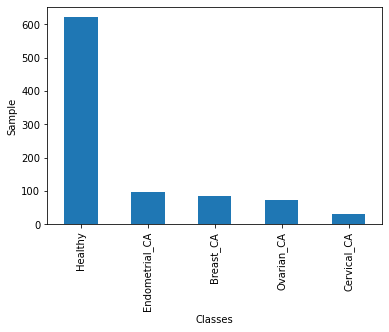

In [7]:
from matplotlib import pyplot as plt
plt.xlabel('Classes')
plt.ylabel('Sample')
dataset['Diagnose'].value_counts().plot(kind='bar')
plt.show()

In [8]:
T_X_train, T_X_test, T_y_train, T_y_test = train_test_split(X, y, shuffle=True, test_size = 0.2,random_state=2019)

# Model Without pre-processing 

In [9]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=2019).fit(T_X_train, T_y_train)
T_y_pred = random_forest.predict(T_X_test)
print('Accuracy score: ' + str(accuracy_score(T_y_test, T_y_pred)))
#print('Recall score: ' + str(recall_score(T_y_test, T_y_pred, average='micro')))
#print('Precision score: ' + str(precision_score(T_y_test, T_y_pred, average='micro')))
#print('F1 score: ' + str(f1_score(T_y_test, T_y_pred, average='micro')))

Accuracy score: 0.7458563535911602


In [10]:
R = recall_score(T_y_test, T_y_pred, average='micro')
P = precision_score(T_y_test, T_y_pred, average='micro')

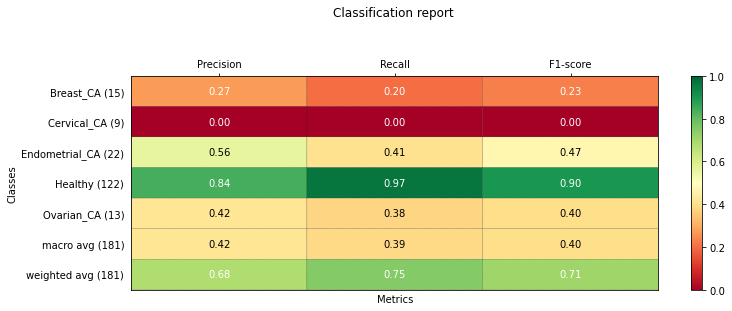

In [11]:
plot_classification_report(classification_report(T_y_test, T_y_pred))

# Model with pre-processing feature normalization, outlier detection using DB scan, Class imbalance resolve using SMOTE

In [12]:
from sklearn.feature_selection import SelectKBest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2

dataset = pd.read_csv('dataset_labeled_all_classes.csv', header = 0)

X = dataset.drop(['Diagnose', 'Nummer-Lab 420'], axis=1)
y = dataset['Diagnose']
from sklearn.cluster import DBSCAN 
#dbscane
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
X_normalized = normalize(X_scaled) 
db = DBSCAN(eps = 0.7).fit(X_normalized) 
print(db)
labels1 = db.labels_ 
from collections import Counter
print(Counter(db.labels_))
outliar_df = pd.DataFrame(X)
list(outliar_df[db.labels_==-1].index)
print("Data sample before removing outliar: ", len(y))
X.drop(list(outliar_df[db.labels_==-1].index), inplace=True)
y.drop(list(outliar_df[db.labels_==-1].index), inplace=True)
print("Data sample After removing outliar: ", len(y))

from imblearn.over_sampling import SMOTE


cc = SMOTE(k_neighbors=1)
T_X_res, T_y_res = cc.fit_resample(X, y)
print("Data sample before Smote model", len(X))
print("Data sample after Smote model", len(T_y_res))
T_X_train, T_X_test, T_y_train, T_y_test = train_test_split(T_X_res, T_y_res, shuffle=True, test_size = 0.2,random_state=2019)

random_forest_S = RandomForestClassifier(n_estimators=500, random_state=2019).fit(T_X_train, T_y_train)
T_y_pred = random_forest_S.predict(T_X_test)
print('Accuracy score: ' + str(accuracy_score(T_y_test, T_y_pred)))
print('Recall score: ' + str(recall_score(T_y_test, T_y_pred, average='weighted')))
print('Precision score: ' + str(precision_score(T_y_test, T_y_pred, average='weighted')))
print('F1 score: ' + str(f1_score(T_y_test, T_y_pred, average='weighted')))

DBSCAN(eps=0.7)
Counter({0: 809, 1: 58, -1: 34, 2: 26})
Data sample before removing outliar:  927
Data sample After removing outliar:  893
Data sample before Smote model 893
Data sample after Smote model 5337
Accuracy score: 0.9887640449438202
Recall score: 0.9887640449438202
Precision score: 0.9889618503606054
F1 score: 0.9886043575738283


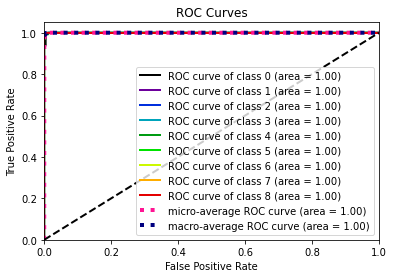

In [13]:
predicted_probas = random_forest_S.predict_proba(T_X_test)

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(T_y_test, predicted_probas)
plt.show()

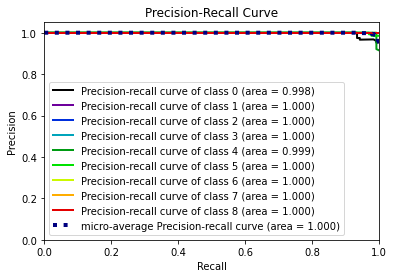

In [14]:
skplt.metrics.plot_precision_recall_curve(T_y_test, predicted_probas)
plt.show()

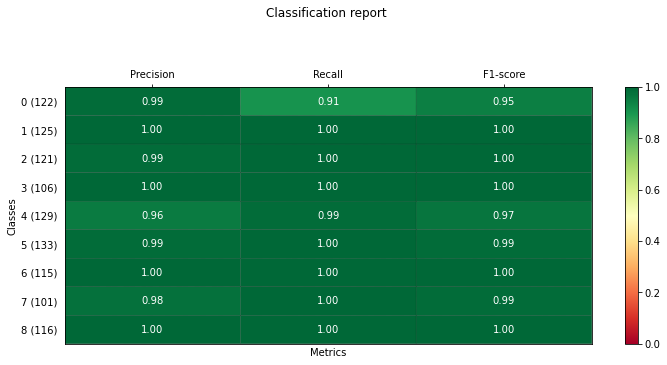

In [15]:
plot_classification_report(classification_report(T_y_test, T_y_pred))

# Sample after the Smote model

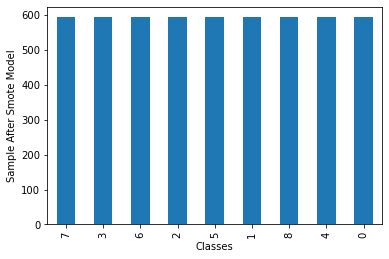

In [16]:
T_X_res['Diagnosis'] = T_y_res
from matplotlib import pyplot as plt
plt.xlabel('Classes')
plt.ylabel('Sample After Smote Model')
T_X_res['Diagnosis'].value_counts().plot(kind='bar')
plt.show()


# # Feature with their score.
## Feature with highest score is more important

In [28]:
feature_scores = pd.Series(random_forest_S.feature_importances_, T_X_train.columns).sort_values(ascending=False)
feature_scores

wl_1680    0.004139
wl_1287    0.004090
wl_1356    0.003708
wl_1678    0.003666
wl_1309    0.003570
             ...   
wl_830     0.000034
wl_1896    0.000034
wl_848     0.000031
wl_1117    0.000029
wl_1964    0.000026
Length: 2541, dtype: float64

In [32]:
feature_scores_df = feature_scores.to_frame()
feature_scores_df.to_csv('features_scores.csv')
feature_scores_df

,0
wl_1680,0.004139
wl_1287,0.004090
wl_1356,0.003708
wl_1678,0.003666
wl_1309,0.003570
...,...
wl_830,0.000034
wl_1896,0.000034
wl_848,0.000031
wl_1117,0.000029


# Model without Smote

In [18]:
dataset = pd.read_csv('dataset_labeled_all_classes.csv', header = 0)
X = dataset.drop(['Diagnose', 'Nummer-Lab 420'], axis=1)
y = dataset['Diagnose']

# Normalize features

In [19]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
X_normalized = normalize(X_scaled) 

# outlier detection

In [20]:
db = DBSCAN(eps = 0.7).fit(X_normalized) 
print(db)
labels1 = db.labels_ 
from collections import Counter
print(Counter(db.labels_))
outliar_df = pd.DataFrame(X)
list(outliar_df[db.labels_==-1].index)
print("Data sample before removing outliar: ", len(y))
X.drop(list(outliar_df[db.labels_==-1].index), inplace=True)
y.drop(list(outliar_df[db.labels_==-1].index), inplace=True)
print("Data sample After removing outliar: ", len(y))

DBSCAN(eps=0.7)
Counter({0: 809, 1: 58, -1: 34, 2: 26})
Data sample before removing outliar:  927
Data sample After removing outliar:  893


# indexes of outlier samples

In [21]:
list(outliar_df[db.labels_==-1].index)

[50,
 70,
 90,
 119,
 135,
 138,
 198,
 199,
 200,
 204,
 205,
 206,
 240,
 241,
 242,
 287,
 288,
 289,
 292,
 293,
 294,
 295,
 296,
 331,
 333,
 334,
 536,
 537,
 559,
 565,
 567,
 590,
 679,
 703]

# outlier sample

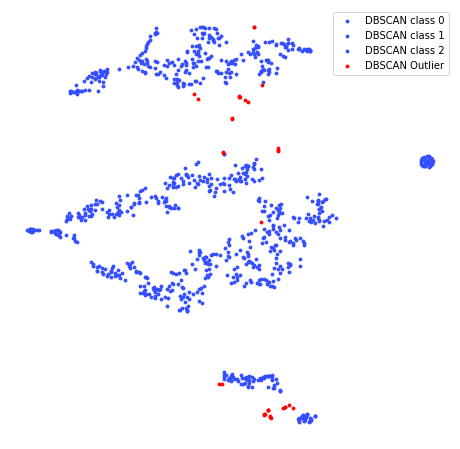

In [22]:
from sklearn.manifold import TSNE
MAX_N_TSNE = 3500 #Avoid overly long computation times with TSNE. Values < 5000 recommended 

assert len(X_normalized) <= MAX_N_TSNE, 'Using a dataset with more than {} points is not recommended'.format(
                                            MAX_N_TSNE)
X_2D = TSNE(n_components=2, perplexity=30, n_iter=400).fit_transform(X_normalized) # collapse in 2-D space for plotting

fig, ax = plt.subplots(1, 1, figsize=(8, 8))


for i in set(db.labels_):
    if i == -1: 
        #outlier according to dbscan
        ax.scatter(X_2D[db.labels_==i, 0], X_2D[db.labels_==i, 1], c='r', s=8, label='DBSCAN Outlier')
    else:
        ax.scatter(X_2D[db.labels_==i, 0], X_2D[db.labels_==i, 1], s=8, c=[[0.2, 0.3, max(i*0.2 + 0.4, 1)],],
                                                                           label='DBSCAN class {}'.format(i))
plt.axis('off')
plt.legend()
plt.show()  

In [23]:
T_X_train, T_X_test, T_y_train, T_y_test = train_test_split(X, y, shuffle=True, test_size = 0.2,random_state=2019)
random_forest = RandomForestClassifier(n_estimators=500, random_state=2019).fit(T_X_train, T_y_train)
T_y_pred = random_forest.predict(T_X_test)
print('Accuracy score: ' + str(accuracy_score(T_y_test, T_y_pred)))
print('Recall score: ' + str(recall_score(T_y_test, T_y_pred, average='weighted')))
print('Precision score: ' + str(precision_score(T_y_test, T_y_pred, average='weighted')))
print('F1 score: ' + str(f1_score(T_y_test, T_y_pred, average='weighted')))

Accuracy score: 0.7262569832402235
Recall score: 0.7262569832402235
Precision score: 0.6655810368840274
F1 score: 0.685031967167271


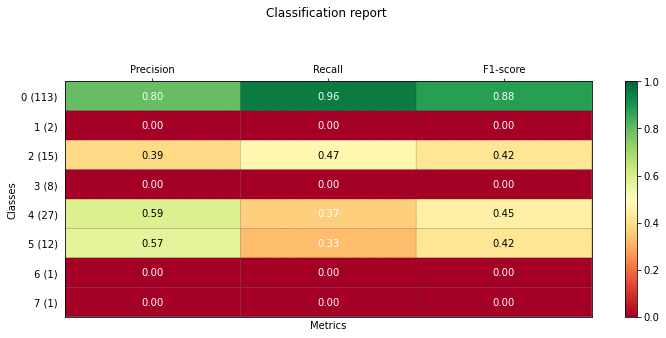

In [24]:
plot_classification_report(classification_report(T_y_test, T_y_pred))

# Feature with their score.
## Feature with highest score is more important

In [25]:
feature_scores = pd.Series(random_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_scores

wl_2464    0.002446
wl_2518    0.002246
wl_2538    0.002028
wl_2489    0.001826
wl_2521    0.001811
             ...   
wl_1119    0.000048
wl_881     0.000046
wl_702     0.000042
wl_1849    0.000040
wl_943     0.000037
Length: 2541, dtype: float64

# Final Model with data augmentation

In [25]:
new_sample = X[0:1]
print("Model Prediction: ", random_forest_S.predict(new_sample)[0])

Model Prediction:  0


#  Final Model without data augmentation

In [26]:
new_sample = X[0:1]
print("Model Prediction: ", random_forest.predict(new_sample)[0])

Model Prediction:  0


In [34]:
print(X[1:2])

       wl_1      wl_2      wl_3      wl_4      wl_5      wl_6      wl_7  \
1  0.994748  0.994386  0.994471  0.994956  0.995422  0.995539  0.995425   

       wl_8      wl_9     wl_10  ...  wl_2532   wl_2533  wl_2534  wl_2535  \
1  0.995358  0.995322  0.995142  ...  0.27183  0.272295  0.27395  0.27637   

    wl_2536   wl_2537   wl_2538   wl_2539   wl_2540   wl_2541  
1  0.278466  0.278616  0.276315  0.273005  0.270592  0.270063  

[1 rows x 2541 columns]


In [41]:
new_sample = X[21:22]
print("Model Prediction: ", random_forest_S.predict(new_sample)[0])

Model Prediction:  5
